Displaying Training Metrics...


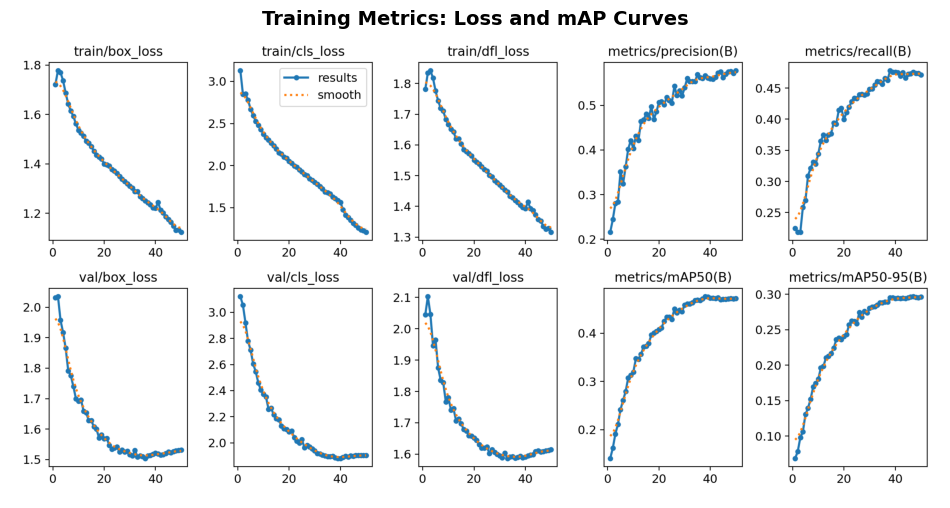

Displaying Confusion Matrix...


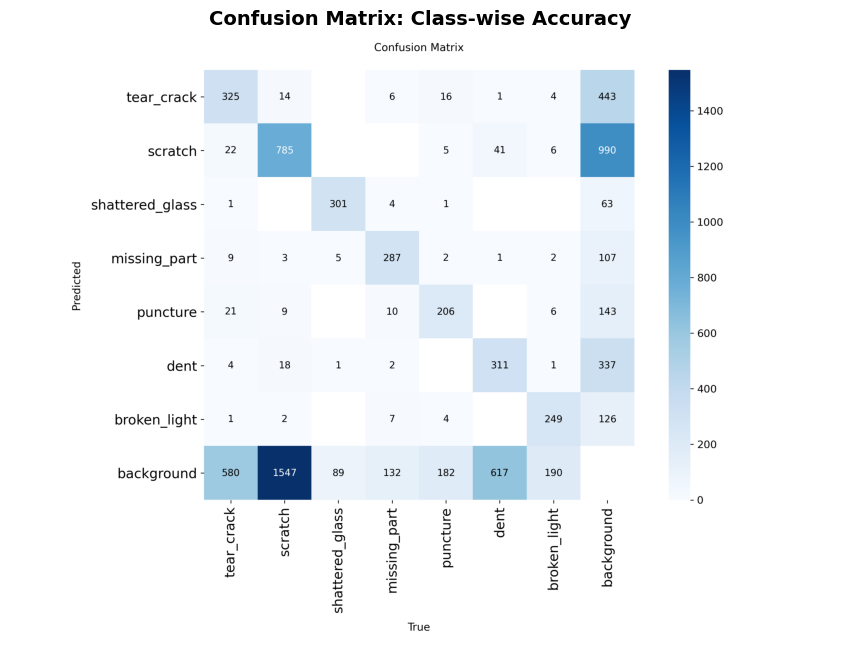

Displaying  F1 Curve...


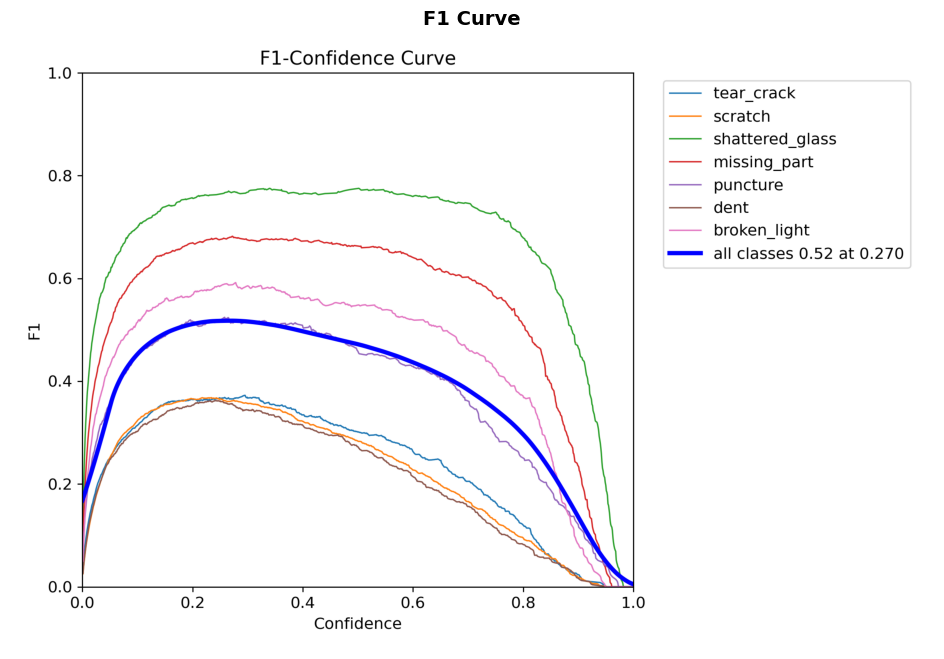

In [15]:
import os
import matplotlib.pyplot as plt
import cv2

# Path to training results
TRAIN_DIR = "/kaggle/input/dl-project/runs/detect/car_damage_7cls_final"

def show_result_plot(filename, title):
    path = os.path.join(TRAIN_DIR, filename)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(title, fontsize=14, fontweight='bold')
        plt.show()
    else:
        print(f"File not found: {path}")

# 1. Training Progress Metrics
print("Displaying Training Metrics...")
show_result_plot("results.png", "Training Metrics: Loss and mAP Curves")

# 2. Confusion Matrix Analysis
print("Displaying Confusion Matrix...")
show_result_plot("confusion_matrix.png", "Confusion Matrix: Class-wise Accuracy")

# 3.  F1 Curve 
print("Displaying  F1 Curve...")
show_result_plot("BoxF1_curve.png", "F1 Curve")

In [24]:
import yaml
import os

# ==========================================
# DYNAMIC CONFIGURATION SETUP
# ==========================================
# This script generates a session-specific YAML file. 
# It ensures the model can find the dataset regardless of the platform/environment.

# Path where the YAML file will be stored in the current session
DATA_CFG = "/kaggle/working/temp_config.yaml"

# Define the dataset structure and class names
config = {
    "path": "/kaggle/input/dl-project/split_data", # Root folder for the dataset
    "train": "train/images",                      # Sub-path for training images
    "val": "val/images",                          # Sub-path for validation images
    "nc": 7,                                      # Number of classes
    
    "names": [
        "tear_crack",       # ID 0
        "scratch",          # ID 1
        "shattered_glass",  # ID 2
        "missing_part",     # ID 3
        "puncture",         # ID 4
        "dent",             # ID 5
        "broken_light"      # ID 6
    ]
}

# Write the configuration to a YAML file in the working directory
with open(DATA_CFG, "w") as f:
    yaml.dump(config, f)

print(f"Session-specific config saved to: {DATA_CFG}")

✅ Session-specific config saved to: /kaggle/working/temp_config.yaml


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.1 MB/s eta 0:00:0000:01


In [3]:
import os
import random
import numpy as np
from ultralytics import YOLO

# 1. Configuration and Initialization
MODEL_PATH = "/kaggle/input/dl-project/runs/detect/car_damage_7cls_final/weights/best.pt"
CONFIG_PATH = "/kaggle/input/temp-config-yaml/temp_config.yaml"

# Search space boundaries
BOUNDS = {
    'conf': (0.10, 0.40), 
    'iou':  (0.40, 0.70)  
}

# GA Hyperparameters
POPULATION_SIZE = 10
GENERATIONS = 5
MUTATION_RATE = 0.2

model = YOLO(MODEL_PATH)

# 2. Genetic Algorithm Functions
def get_fitness(individual):
    """Objective Function: Evaluates mAP score for given Conf and IoU."""
    conf, iou = individual
    metrics = model.val(data=CONFIG_PATH, split="val", conf=conf, iou=iou, verbose=False, plots=False)
    return metrics.box.map50

def create_individual():
    """Creates a random chromosome (individual)."""
    return [random.uniform(BOUNDS['conf'][0], BOUNDS['conf'][1]), 
            random.uniform(BOUNDS['iou'][0], BOUNDS['iou'][1])]

def crossover(parent1, parent2):
    """Crossover: Produces offspring from two parents."""
    return [parent1[0], parent2[1]], [parent2[0], parent1[1]]

def mutate(individual):
    """Mutation: Randomly alters genes to maintain diversity."""
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            key = 'conf' if i == 0 else 'iou'
            individual[i] = random.uniform(BOUNDS[key][0], BOUNDS[key][1])
    return individual

# 3. Evolutionary Process
print("Starting Genetic Algorithm Optimization...")
population = [create_individual() for _ in range(POPULATION_SIZE)]
best_solution, best_score = None, 0

for gen in range(GENERATIONS):
    print(f"Processing Generation {gen+1}/{GENERATIONS}...")
    
    scored_population = []
    for ind in population:
        score = get_fitness(ind)
        scored_population.append((ind, score))
        if score > best_score:
            best_score, best_solution = score, ind
            print(f"New Best Found: Score {score:.4f} (Conf={ind[0]:.3f}, IoU={ind[1]:.3f})")
    
    scored_population.sort(key=lambda x: x[1], reverse=True)
    top_half = [x[0] for x in scored_population[:POPULATION_SIZE//2]]
    
    new_population = []
    while len(new_population) < POPULATION_SIZE:
        p1, p2 = random.choice(top_half), random.choice(top_half)
        c1, c2 = crossover(p1, p2)
        new_population.extend([mutate(c1), mutate(c2)])
    population = new_population[:POPULATION_SIZE]

print("\nOptimization Complete")
print(f"Optimal Confidence: {best_solution[0]:.4f}")
print(f"Optimal IoU: {best_solution[1]:.4f}")
print(f"Maximized mAP: {best_score:.4f}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Starting Genetic Algorithm Optimization...
Processing Generation 1/5...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 57.7±10.8 MB/s, size: 193.5 KB)
val: Scanning /kaggle/input/dl-project/split_data/val/labels... 2322 images, 0 backgrounds, 2 corrupt: 100% ━━━━━━━━━━━━ 2324/2324 339.0it/s 6.9s0.0s
val: /kaggle/input/dl-project/split_data/val/images/24032020_094730image64439.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: /kaggle/input/dl-project/split_data/val/images/2403202

In [4]:
from ultralytics import YOLO

# ==========================================
# 1. SETTINGS (GA OPTIMIZED RESULTS)
# ==========================================
# Applying the best values found by the Genetic Algorithm
OPTIMAL_CONF = 0.3605
OPTIMAL_IOU  = 0.4127

# File Paths
MODEL_PATH  = "/kaggle/input/best-pt/best (1).pt"
CONFIG_PATH = "/kaggle/input/temp-config-yaml/temp_config.yaml"

# ==========================================
# 2. VALIDATION REPORT
# ==========================================
print("REPORTING WITH OPTIMIZED PARAMETERS...")
print(f"   - Confidence Threshold: {OPTIMAL_CONF}")
print(f"   - IoU Threshold: {OPTIMAL_IOU}")
print("-" * 60)

# Load the model
model = YOLO(MODEL_PATH)

# Start validation (verbose=True provides per-class metrics)
metrics = model.val(
    data=CONFIG_PATH,
    split='val',           # Using the validation set
    conf=OPTIMAL_CONF,     # Optimized Confidence
    iou=OPTIMAL_IOU,       # Optimized IoU
    verbose=True,          # Show detailed class-wise table
    plots=True             # Generate Confusion Matrix and PR Curves
)

print("-" * 60)
print(f"FINAL mAP@50 Score: {metrics.box.map50:.4f}")
print(f"FINAL Precision   : {metrics.box.mp:.4f}")
print(f"FINAL Recall      : {metrics.box.mr:.4f}")
print("-" * 60)

REPORTING WITH OPTIMIZED PARAMETERS...
   - Confidence Threshold: 0.3605
   - IoU Threshold: 0.4127
------------------------------------------------------------
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 300.7±115.4 MB/s, size: 180.8 KB)
val: Scanning /kaggle/input/dl-project/split_data/val/labels... 2322 images, 0 backgrounds, 2 corrupt: 100% ━━━━━━━━━━━━ 2324/2324 1.1Kit/s 2.1s0.1s
val: /kaggle/input/dl-project/split_data/val/images/24032020_094730image64439.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: /kaggle/input/dl-project/split_data/val/images/24032020_140438image435324.jpg: ignoring corrupt image/label: image file is truncated (83 bytes not processed)
WARNING ⚠️ val: Cache directory /kaggle/input/dl-project/split_data/val is not writable, cache not saved.
           

In [5]:
from ultralytics import YOLO
import torch
import numpy as np

# ==========================================
# 1. SETTINGS
# ==========================================
MODEL_PATH = "/kaggle/input/dl-project/runs/detect/car_damage_7cls_final/weights/best.pt"
CONFIG_PATH = "/kaggle/input/temp-config-yaml/temp_config.yaml"

# Values to test for Grid Search
# Standard YOLO uses conf=0.25, iou=0.70. We are searching for better parameters.
conf_values = [0.15, 0.20, 0.25, 0.30] 
iou_values  = [0.45, 0.50, 0.60, 0.70]

# ==========================================
# 2. OPTIMIZATION LOOP
# ==========================================
print("Starting Grid Search Optimization...")
print(f"Total Combinations to Test: {len(conf_values) * len(iou_values)}")

try:
    model = YOLO(MODEL_PATH)
except Exception as e:
    print(f"Error loading model. Check path: {MODEL_PATH}")
    raise e

best_map = 0
best_conf = 0
best_iou = 0
results_log = []

for conf in conf_values:
    for iou in iou_values:
        print(f"Testing -> Conf: {conf}, IoU: {iou} ...", end="")
        
        # Run validation test
        metrics = model.val(
            data=CONFIG_PATH,
            split="val",
            conf=conf,
            iou=iou,
            augment=False, 
            verbose=False,
            plots=False
        )
        
        current_map = metrics.box.map50
        results_log.append((conf, iou, current_map))
        print(f" mAP50: {current_map:.4f}")
        
        # Update best results
        if current_map > best_map:
            best_map = current_map
            best_conf = conf
            best_iou = iou

# ==========================================
# 3. FINAL REPORT (FOR PRESENTATION)
# ==========================================
print("\n" + "="*40)
print("       OPTIMIZATION RESULTS       ")
print("="*40)
print(f"Highest Score (mAP50): {best_map:.4f}")
print(f"Optimal Confidence    : {best_conf}")
print(f"Optimal IoU           : {best_iou}")
print("="*40)

print("\nPerformance Ranking Table:")
print(f"{'Conf':<10} {'IoU':<10} {'mAP50':<10}")
print("-" * 30)
for r in sorted(results_log, key=lambda x: x[2], reverse=True):
    print(f"{r[0]:<10} {r[1]:<10} {r[2]:.4f}")

Starting Grid Search Optimization...
Total Combinations to Test: 16
Testing -> Conf: 0.15, IoU: 0.45 ...Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 320.8±131.4 MB/s, size: 174.3 KB)
val: Scanning /kaggle/input/dl-project/split_data/val/labels... 2322 images, 0 backgrounds, 2 corrupt: 100% ━━━━━━━━━━━━ 2324/2324 1.1Kit/s 2.1s0.1s
val: /kaggle/input/dl-project/split_data/val/images/24032020_094730image64439.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: /kaggle/input/dl-project/split_data/val/images/24032020_140438image435324.jpg: ignoring corrupt image/label: image file is truncated (83 bytes not processed)
WARNING ⚠️ val: Cache directory /kaggle/input/dl-project/split_data/val is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R  

In [6]:
from ultralytics import YOLO

# ==========================================
# 1. SETTINGS (GA + TTA)
# ==========================================
# Using optimal values found via Genetic Algorithm
OPTIMAL_CONF = 0.3605
OPTIMAL_IOU  = 0.4127

MODEL_PATH  = "/kaggle/input/dl-project/runs/detect/car_damage_7cls_final/weights/best.pt"
CONFIG_PATH = "/kaggle/input/temp-config-yaml/temp_config.yaml"

# ==========================================
# 2. FINAL VALIDATION - TTA ENABLED
# ==========================================
print("MEASURING FINAL PERFORMANCE (GA + TTA)...")
print(f"   - Confidence Threshold: {OPTIMAL_CONF}")
print(f"   - IoU Threshold       : {OPTIMAL_IOU}")
print(f"   - TTA (Augment)       : ENABLED")
print("-" * 60)

model = YOLO(MODEL_PATH)

# Measuring with TTA (augment=True)
metrics = model.val(
    data=CONFIG_PATH,
    split='val',
    conf=OPTIMAL_CONF,
    iou=OPTIMAL_IOU,
    augment=True,      # This enables Test Time Augmentation
    verbose=True,
    plots=False        # Disabled plots for faster processing
)

print("-" * 60)
print(f"Final TTA-enhanced mAP@50 : {metrics.box.map50:.4f}")
print(f"Final TTA-enhanced Precision: {metrics.box.mp:.4f}")
print(f"Final TTA-enhanced Recall   : {metrics.box.mr:.4f}")
print("-" * 60)

MEASURING FINAL PERFORMANCE (GA + TTA)...
   - Confidence Threshold: 0.3605
   - IoU Threshold       : 0.4127
   - TTA (Augment)       : ENABLED
------------------------------------------------------------
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 285.3±92.8 MB/s, size: 171.9 KB)
val: Scanning /kaggle/input/dl-project/split_data/val/labels... 2322 images, 0 backgrounds, 2 corrupt: 100% ━━━━━━━━━━━━ 2324/2324 1.1Kit/s 2.1s0.0s
val: /kaggle/input/dl-project/split_data/val/images/24032020_094730image64439.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: /kaggle/input/dl-project/split_data/val/images/24032020_140438image435324.jpg: ignoring corrupt image/label: image file is truncated (83 bytes not processed)
WARNING ⚠️ val: Cache directory /kaggle/input/dl-project/split_data/val i

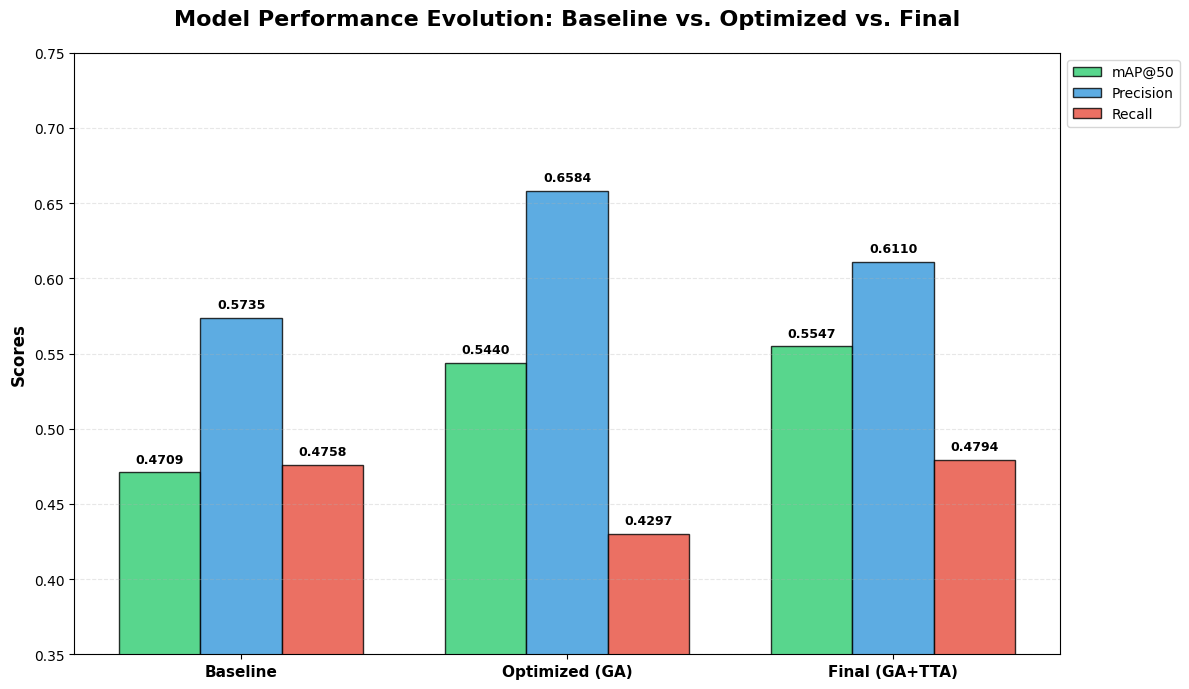

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Updated Data (Baseline: 0.4709)
labels = ['Baseline', 'Optimized (GA)', 'Final (GA+TTA)']
map_scores = [0.4709, 0.5440, 0.5547]
precision_scores = [0.5735, 0.6584, 0.6110]
recall_scores = [0.4758, 0.4297, 0.4794]

x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

# Creating the bars
rects1 = ax.bar(x - width, map_scores, width, label='mAP@50', color='#2ecc71', edgecolor='black', alpha=0.8)
rects2 = ax.bar(x, precision_scores, width, label='Precision', color='#3498db', edgecolor='black', alpha=0.8)
rects3 = ax.bar(x + width, recall_scores, width, label='Recall', color='#e74c3c', edgecolor='black', alpha=0.8)

# Axis and Title Settings
ax.set_ylabel('Scores', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Evolution: Baseline vs. Optimized vs. Final', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Function to add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Aesthetic improvements
plt.ylim(0.35, 0.75) 
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('performance_comparison_final.png', dpi=300)
plt.show()

In [23]:
import os
import glob
import random

# ==========================================================
# ALL IN-PERSON DATA (COMPLETE PREDICTION)
# ==========================================================
print("\n" + "="*50)
print("SCENARIO A: IN-PERSON (FULL DIRECTORY + TTA)")
print("="*50)

# Direct path to the In-Person dataset in Kaggle environment
DIRECT_IN_PERSON_PATH = "/kaggle/input/in-person-test-data/In_Person"

if os.path.exists(DIRECT_IN_PERSON_PATH):
    # Fetch and sort every valid image file to ensure consistent testing
    in_person_imgs = sorted(glob.glob(os.path.join(DIRECT_IN_PERSON_PATH, "*.*")))
    in_person_imgs = [x for x in in_person_imgs if x.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]
    
    print(f"DEBUG: Found {len(in_person_imgs)} images at {DIRECT_IN_PERSON_PATH}")
    
    if len(in_person_imgs) > 0:
        print("Status: Starting Full Inference for In-Person images...")
        # Running the full local dataset validates real-world reliability without selection bias
        model.predict(
            source=in_person_imgs,
            save=True,               # Save images with visualized bounding boxes
            conf=BEST_CONF,          # Applying GA-Optimized Confidence threshold (e.g., 0.36)
            iou=BEST_IOU,            # Applying GA-Optimized IoU threshold (e.g., 0.41)
            augment=True,            # Enable Test Time Augmentation (TTA) for multi-angle robustness
            device=device,
            project=OUTPUT_BASE,
            name="final_in_person_complete",
            exist_ok=True,
            verbose=True             # Enabling verbose to monitor per-image latency and results
        )
    else:
        print("WARNING: No valid images found in In-Person directory!")
else:
    print(f"ERROR: Directory NOT found: {DIRECT_IN_PERSON_PATH}")

# ==========================================================
# BING DATA (RANDOM 200 SAMPLES)
# ==========================================================
print("\n" + "="*50)
print("SCENARIO B: BING DATA (200 RANDOM SAMPLES + TTA)")
print("="*50)

# Direct path to the Bing dataset in Kaggle environment
DIRECT_BING_PATH = "/kaggle/input/dataset-bing/dataset_raw_bing"

if os.path.exists(DIRECT_BING_PATH):
    # Perform a recursive search for all images across nested directories
    all_bing = glob.glob(os.path.join(DIRECT_BING_PATH, "**", "*.*"), recursive=True)
    all_bing = [x for x in all_bing if x.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"DEBUG: Found {len(all_bing)} total images at {DIRECT_BING_PATH}")
    
    if len(all_bing) > 0:
        # Sampling 200 images provides a diverse web-data validation set while optimizing compute time
        sample_size = min(200, len(all_bing))
        selected_bing = random.sample(all_bing, sample_size)
        print(f"Status: Starting Inference for {sample_size} random Bing images...")
        
        model.predict(
            source=selected_bing,
            save=True,
            conf=BEST_CONF,
            iou=BEST_IOU,
            augment=True,
            device=device,
            project=OUTPUT_BASE,
            name="final_bing_optimized_200", 
            exist_ok=True,
            verbose=True 
        )
        print("Bing 200 Samples Optimized Inference Complete.")
    else:
        print("WARNING: No valid images found in Bing directory!")
else:
    print(f"ERROR: Directory NOT found: {DIRECT_BING_PATH}")


SCENARIO A: IN-PERSON (FULL DIRECTORY + TTA)
DEBUG: Found 24 images at /kaggle/input/in-person-test-data/In_Person
Status: Starting Full Inference for In-Person images...

0: 640x640 1 missing_part, 23.9ms
1: 640x640 1 missing_part, 23.9ms
2: 640x640 1 missing_part, 23.9ms
3: 640x640 1 missing_part, 23.9ms
4: 640x640 1 missing_part, 23.9ms
5: 640x640 1 scratch, 1 missing_part, 1 dent, 23.9ms
6: 640x640 1 missing_part, 1 broken_light, 23.9ms
7: 640x640 1 missing_part, 23.9ms
8: 640x640 2 scratchs, 1 missing_part, 23.9ms
9: 640x640 1 tear_crack, 23.9ms
10: 640x640 4 tear_cracks, 1 puncture, 1 dent, 1 broken_light, 23.9ms
11: 640x640 1 missing_part, 23.9ms
12: 640x640 (no detections), 23.9ms
13: 640x640 1 missing_part, 23.9ms
14: 640x640 2 missing_parts, 1 dent, 23.9ms
15: 640x640 1 tear_crack, 1 dent, 23.9ms
16: 640x640 1 scratch, 1 missing_part, 23.9ms
17: 640x640 1 scratch, 1 dent, 23.9ms
18: 640x640 1 broken_light, 23.9ms
19: 640x640 1 tear_crack, 1 missing_part, 23.9ms
20: 640x640 1

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0: 640x640 1 missing_part, 24.5ms
1: 640x640 1 tear_crack, 1 scratch, 1 dent, 24.5ms
2: 640x640 1 missing_part, 24.5ms
3: 640x640 1 tear_crack, 1 missing_part, 1 dent, 24.5ms
4: 640x640 1 tear_crack, 1 missing_part, 1 dent, 24.5ms
5: 640x640 1 scratch, 1 dent, 24.5ms
6: 640x640 1 missing_part, 2 dents, 24.5ms
7: 640x640 2 tear_cracks, 1 broken_light, 24.5ms
8: 640x640 1 shattered_glass, 24.5ms
9: 640x640 1 missing_part, 24.5ms
10: 640x640 1 missing_part, 24.5ms
11: 640x640 2 dents, 24.5ms
12: 640x640 1 missing_part, 24.5ms
13: 640x640 1 missing_part, 24.5ms
14: 640x640 1 shattered_glass, 24.5ms
15: 640x640 2 scratchs, 24.5ms
16: 640x640 2 scratchs, 1 dent, 24.5ms
17: 640x640 1 scratch, 24.5ms
18: 640x640 2 scratchs, 1 missing_part, 24.5ms
19: 640x640 2 dents, 24.5ms
20: 640x640 1 dent, 24.5ms
21: 640x640 1 missing_part, 1 dent, 24.5ms
22: 640x640 1 missing_part, 24.5ms
23: 640x640 1 broken_light, 24.5ms
24: 640x640 1 dent, 24.5ms
25: 640x640 1 shattered_glass, 24.5ms
26: 640x640 2 miss